In [1]:
# Imports
import pandas as pd
import numpy as np
import datetime
from datetime import time as dtime
from datetime import timedelta
from datetime import date
import matplotlib as plt
from itertools import product
import openpyxl

# importing historical data for backtest
def get1minBars(csvName):
    
    priceData1minBars_df = pd.read_csv(csvName, usecols=['date', 'open', 'high', 'low', 'close', 'volume'])
    
    # Parse datetime column and divide in 2 columns
    # SPY_Data['datetime'] = pd.to_datetime(SPY_Data['date'].str.strip(), format='%Y%m%d %H:%M:%S')
    priceData1minBars_df.rename(columns={
        'date': 'datetime'
    }, inplace=True)
    
    priceData1minBars_df['datetime'] = pd.to_datetime(priceData1minBars_df['datetime'])
    
    priceData1minBars_df['Date'] = priceData1minBars_df['datetime'].dt.date
    priceData1minBars_df['Time'] = priceData1minBars_df['datetime'].dt.time
    
    # sorting the data by the time column to make sure it is consistent
    priceData1minBars_df.sort_values('datetime', inplace=True)
    
    # Drop original 'date' column
    # SPY_Data.drop(columns=['date'], inplace=True)
    
    # Filter for regular trading hours using datetime column
    priceData1minBars_df = priceData1minBars_df[priceData1minBars_df['datetime'].dt.time >= pd.to_datetime("09:30").time()]
    priceData1minBars_df = priceData1minBars_df[priceData1minBars_df['datetime'].dt.time <= pd.to_datetime("16:00").time()]
    
    # Making sure the order of the columns stays the same 
    priceData1minBars_df = priceData1minBars_df[['Date', 'Time', 'open', 'high', 'low', 'close', 'volume']]
    
    return priceData1minBars_df
    
    


In [2]:
SPY_Data = get1minBars('SPY_1min_data.csv')
SPY_Data

,Date,Time,open,high,low,close,volume
0,2019-12-31,09:30:00,320.52,320.53,320.24,320.27,4255
1,2019-12-31,09:31:00,320.27,320.34,320.15,320.33,2049
2,2019-12-31,09:32:00,320.35,320.97,320.35,320.97,2953
3,2019-12-31,09:33:00,320.98,321.05,320.81,320.82,2529
4,2019-12-31,09:34:00,320.83,320.91,320.74,320.80,1373
...,...,...,...,...,...,...,...
507925,2025-08-01,15:55:00,622.10,622.29,621.64,622.25,7142
507926,2025-08-01,15:56:00,622.27,622.53,622.12,622.46,6161
507927,2025-08-01,15:57:00,622.46,622.53,622.22,622.38,7356
507928,2025-08-01,15:58:00,622.39,622.44,621.95,621.96,10144


In [3]:
# higher time frame datageneration

# Uses your adx(df, period=14) that returns ['+DI','-DI','DX','ADX'] on OHLC.
def adx(df, period: int = 14,
        high_col: str = "high", 
        low_col: str = "low", 
        close_col: str = "close"):
    """
    Returns a DataFrame with columns: +DI, -DI, DX, ADX computed with Wilder's smoothing.
    df must have High/Low/Close columns.
    """
    high, low, close = df[high_col].astype(float), df[low_col].astype(float), df[close_col].astype(float)

    # 1) True Range
    prev_close = close.shift(1)
    tr = pd.concat([
        (high - low),
        (high - prev_close).abs(),
        (low - prev_close).abs()
    ], axis=1).max(axis=1)

    # 2) Directional Movement
    up_move = high.diff()
    down_move = -low.diff()  # prev_low - curr_low
    plus_dm  = np.where((up_move > down_move) & (up_move > 0), up_move, 0.0)
    minus_dm = np.where((down_move > up_move) & (down_move > 0), down_move, 0.0)
    plus_dm  = pd.Series(plus_dm, index=df.index)
    minus_dm = pd.Series(minus_dm, index=df.index)

    # 3) Wilder's smoothing (RMA) via EMA with alpha=1/period
    alpha = 1 / period
    atr        = tr.ewm(alpha=alpha, adjust=False).mean()
    plus_dm_sm = plus_dm.ewm(alpha=alpha, adjust=False).mean()
    minus_dm_sm= minus_dm.ewm(alpha=alpha, adjust=False).mean()

    # 4) DIs
    plus_di  = 100 * (plus_dm_sm / atr)
    minus_di = 100 * (minus_dm_sm / atr)

    # 5) DX
    di_sum  = (plus_di + minus_di)
    di_diff = (plus_di - minus_di).abs()
    dx = 100 * (di_diff / di_sum.replace(0, np.nan))

    # 6) ADX
    adx = dx.ewm(alpha=alpha, adjust=False).mean()

    out = pd.DataFrame({
        "+DI": plus_di,
        "-DI": minus_di,
        "DX": dx,
        "ADX": adx
    })
    return out



def adx_HTF(df):
    
    df = df.copy(deep=True)
    
    df['datetime'] = pd.to_datetime(
        df['Date'].astype(str) + ' ' + df['Time'].astype(str)
    )
    
    df_1H = (
        df
        .set_index('datetime')
        .resample('60min', origin='start_day', offset='30min')
        .agg({'open':'first','high':'max','low':'min','close':'last','volume':'sum'})
        .dropna(subset=['open','high','low','close'])
        .reset_index()
    )
    
    df_1H['Date'] = df_1H['datetime'].dt.date
    df_1H['Time'] = df_1H['datetime'].dt.time
    df_1H = df_1H[['Date','Time','open','high','low','close','volume']]
   
        # df has columns: open, high, low, close, volume
    df_1H['ema20'] = df_1H['close'].ewm(span=20, adjust=False).mean().rename('EMA20').shift(1)
    df_1H['ema50'] = df_1H['close'].ewm(span=50, adjust=False).mean().rename('EMA50').shift(1)
    
    # Alignment (1 if uptrend, 0 if downtrend)
    df_1H['ema_alignment'] = (df_1H['ema20'] > df_1H['ema50']).astype(int).rename('EMA_alignment')
        
    # 2) HTF DMI/ADX
    adx_1H = adx(df_1H, period=14)
    df_1H['ADX60']  = adx_1H['ADX'].shift(1)
    df_1H['DIp60']  = adx_1H['+DI'].shift(1)
    df_1H['DIn60']  = adx_1H['-DI'].shift(1)
    df_1H['ADX60_rising3'] = (df_1H['ADX60'] > df_1H['ADX60'].shift(1)) & (df_1H['ADX60'].shift(1) > df_1H['ADX60'].shift(2))
    
    return df_1H



def true_range(df, high_col="high", low_col="low", close_col="close"):
    """
    Wilder's True Range (TR) per bar.
    TR_t = max( high_t - low_t, |high_t - close_{t-1}|, |low_t - close_{t-1}| )
    Returns a pd.Series named 'TR'.
    """
    high  = df[high_col].astype(float)
    low   = df[low_col].astype(float)
    close = df[close_col].astype(float)

    prev_close = close.shift(1)
    tr = pd.concat([
        high - low,
        (high - prev_close).abs(),
        (low  - prev_close).abs()
    ], axis=1).max(axis=1)

    tr.name = "TR"
    return tr


def ATR(df, period: int = 14,
        high_col: str = "high",
        low_col: str = "low",
        close_col: str = "close",
        method: str = "wilder"):
    """
    Average True Range (ATR) over `period`.
    method='wilder' uses RMA (EMA with alpha=1/period), which is the standard.
    method='sma' uses a simple moving average.
    Returns a pd.Series named f'ATR_{period}'.
    """
    tr = true_range(df, high_col, low_col, close_col)

    if method.lower() == "wilder":
        atr = tr.ewm(alpha=1/period, adjust=False).mean()
    elif method.lower() == "sma":
        atr = tr.rolling(window=period, min_periods=period).mean()
    else:
        raise ValueError("method must be 'wilder' or 'sma'")

    atr.name = f"ATR_{period}"
    return atr


def NATR(df, period: int = 14,
         high_col: str = "high",
         low_col: str = "low",
         close_col: str = "close",
         as_percent: bool = False,
         method: str = "wilder"):
    """
    Normalized ATR = ATR / Close  (dimensionless volatility).
    If as_percent=True, returns percentage (×100).
    Returns a pd.Series named f'NATR_{period}' (or '%').
    """
    df['ATR'] = ATR(df, period, high_col, low_col, close_col, method=method)
    close = df[close_col].astype(float)

    df['NATR'] = (df['ATR'] / close).replace([np.inf, -np.inf], np.nan)
    if as_percent:
        df['NATR'] = 100.0 * df['NATR']
    
    # patching future leak
    df['ATR'] = df['ATR'].shift(1)
    df['NATR'] = df['NATR'].shift(1)
    
    # renaming a column
    df = df.rename(columns={'volume': 'volume60'})
    
    return df


# generate the HTF data
def HTF(df):
    
    df = df.copy(deep=True)
    
    # calculate ADX on higher timeframe (1h bars)
    htf = adx_HTF(df)
    
    # calculate the NATR on the HTF (1h bars)
    htf = NATR(htf)
    
    return htf

In [4]:
htf_test = HTF(SPY_Data)
htf_test

,Date,Time,open,high,low,close,volume60,ema20,ema50,ema_alignment,ADX60,DIp60,DIn60,ADX60_rising3,ATR,NATR
0,2019-12-31,09:30:00,320.52,321.54,320.15,320.78,55212,NaN,NaN,0,NaN,NaN,NaN,False,NaN,NaN
1,2019-12-31,10:30:00,320.78,320.87,320.39,320.51,36136,320.780000,320.780000,0,NaN,0.000000,0.000000,False,1.390000,0.004333
2,2019-12-31,11:30:00,320.51,320.88,320.30,320.66,26634,320.754286,320.769412,0,NaN,0.000000,0.000000,False,1.325000,0.004134
3,2019-12-31,12:30:00,320.65,320.82,320.58,320.73,21344,320.745306,320.765121,0,100.000000,0.000000,0.505476,False,1.271786,0.003966
4,2019-12-31,13:30:00,320.72,321.03,320.72,321.02,26587,320.743848,320.763744,0,100.000000,0.000000,0.498243,False,1.198087,0.003735
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9779,2025-08-01,11:30:00,621.51,624.97,621.38,624.21,103595,632.830361,633.309401,0,25.823801,10.663527,46.998798,True,3.107280,0.005000
9780,2025-08-01,12:30:00,624.21,624.46,620.33,620.57,137281,632.009374,632.952561,0,28.047066,11.839346,43.162784,True,3.141760,0.005033
9781,2025-08-01,13:30:00,620.57,621.81,619.29,621.62,108451,630.919910,632.466971,0,30.248836,10.752101,41.533751,True,3.212348,0.005176
9782,2025-08-01,14:30:00,621.63,623.11,620.95,621.79,142412,630.034204,632.041599,0,32.426900,10.140201,41.518732,True,3.162895,0.005088


In [5]:
# get first breach out of ORB

def get_opening_range(df, date):
    day_df = df[df['Date'] == date].copy()
    mask = (day_df['Time'] >= pd.to_datetime("09:30").time()) & \
           (day_df['Time'] <  pd.to_datetime("9:45").time())
    or_data = day_df.loc[mask]
    if or_data.empty:
        return None, None
    return or_data['high'].max(), or_data['low'].min()


def get_first_breach(df, date):
    high_or, low_or = get_opening_range(df, date)
    if high_or is None:
        return None

    day_df = df[df['Date'] == date].copy()
    # only consider after OR is formed
    intraday = day_df[day_df['Time'] >= pd.to_datetime("9:45").time()]

    for _, row in intraday.iterrows():
        if row['close'] > high_or:   # breach to upside
            return {
                'Date': date,
                'timeBreach': row['Time'],
                'breach': 'high',
                'OR_high': high_or,
                'OR_low': low_or,
            }
        elif row['close'] < low_or:   # breach to downside
            return {
                'Date': date,
                'timeBreach': row['Time'],
                'breach': 'low',
                'OR_high': high_or,
                'OR_low': low_or,
            }
    return None


# get the first retest after the breach
def get_first_retest(data_df, date, breach_df):
    
    day_df = data_df[data_df['Date'] == date].copy()
    breachInfo = breach_df[breach_df['Date'] == date].copy()
    
    high_or = breachInfo['OR_high'].iloc[0]
    low_or = breachInfo['OR_low'].iloc[0]
    timeBreach = breachInfo['timeBreach'].iloc[0]
    typeBreach = breachInfo['breach'].iloc[0]
    
    # only consider after first OR breach
    intraday = day_df[day_df['Time'] > pd.to_datetime(str(timeBreach)).time()]
    
    fullBreach = False
    
    for _, row in intraday.iterrows():
        
        if typeBreach == 'high':
            if row['low'] > high_or :
                fullBreach = True # we can start looking for a real retest now
        elif typeBreach == 'low':
            if row['high'] < low_or :
                fullBreach = True # we can start looking for a real retest now
        
        if fullBreach == True:
            if typeBreach == 'high':
                if row['low'] <= high_or:   # retest
                    return {
                        'Date': date,
                        'timeBreach': timeBreach,
                        'breach': typeBreach,
                        'OR_high': high_or,
                        'OR_low': low_or,
                        'timeRetest': row['Time']
                    }
            elif typeBreach == 'low':
                if row['high'] >= low_or:   # retest
                    return {
                        'Date': date,
                        'timeBreach': timeBreach,
                        'breach': typeBreach,
                        'OR_high': high_or,
                        'OR_low': low_or,
                        'timeRetest': row['Time']
                    }
    return None

# detect confirmation bar out of ORB after retest
def detectConfirmation(data_df, date, retests_df):
    
    day_df = data_df[data_df['Date'] == date].copy()
    retestInfo = retests_df[retests_df['Date'] == date].copy()
    
    high_or = retestInfo['OR_high'].iloc[0]
    low_or = retestInfo['OR_low'].iloc[0]
    timeRetest = retestInfo['timeRetest'].iloc[0]
    typeBreach = retestInfo['breach'].iloc[0]

    # only consider after first OR breach
    intraday = day_df[day_df['Time'] > pd.to_datetime(str(timeRetest)).time()]
    
    confirmationBar = False
    
    for _, row in intraday.iterrows():
        
        if typeBreach == 'high':
            if row['low'] > high_or :
                confirmationBar = True # we can start looking for a real retest now
        elif typeBreach == 'low':
            if row['high'] < low_or :
                confirmationBar = True # we can start looking for a real retest now
        
        if confirmationBar == True:
            if typeBreach == 'high':
 
                return {
                    'Date': date,
                    'timeBreach': retestInfo['timeBreach'].iloc[0],
                    'breach': typeBreach,
                    'OR_high': high_or,
                    'OR_low': low_or,
                    'timeRetest': timeRetest,
                    'timeConfirmationBar': row['Time']
                }
            elif typeBreach == 'low':
                return {
                    'Date': date,
                    'timeBreach': retestInfo['timeBreach'].iloc[0],
                    'breach': typeBreach,
                    'OR_high': high_or,
                    'OR_low': low_or,
                    'timeRetest': timeRetest,
                    'timeConfirmationBar': row['Time']
                }
    return None



def getORB_retest_data(df):
    
    df = df.copy(deep=True)
    
    breaches = []
    for d in SPY_Data['Date'].unique():
        b = get_first_breach(SPY_Data, d)
        if b:
            breaches.append(b)
    
    breach_df = pd.DataFrame(breaches)
    breach_df
    
    
    
    retests = []
    for d in breach_df['Date'].unique():
        b = get_first_retest(SPY_Data, d, breach_df)
        if b:
            retests.append(b)
    
    retests_df = pd.DataFrame(retests)
    retests_df
    
    
    
    confirmationBars = []
    for d in retests_df['Date'].unique():
        b = detectConfirmation(SPY_Data, d, retests_df)
        if b:
            confirmationBars.append(b)
    
    confirmationBar_df = pd.DataFrame(confirmationBars)
    
    return confirmationBar_df



In [6]:
BO_and_retest = getORB_retest_data(SPY_Data)
BO_and_retest

,Date,timeBreach,breach,OR_high,OR_low,timeRetest,timeConfirmationBar
0,2019-12-31,09:47:00,high,321.34,320.15,09:50:00,15:30:00
1,2020-01-02,10:11:00,low,324.00,323.41,12:41:00,12:42:00
2,2020-01-03,10:42:00,high,322.94,321.10,10:46:00,11:45:00
3,2020-01-06,09:46:00,high,321.43,320.36,09:55:00,09:57:00
4,2020-01-08,09:53:00,high,323.54,322.67,10:24:00,11:13:00
...,...,...,...,...,...,...,...
1090,2025-07-24,09:47:00,high,634.91,633.99,09:54:00,09:59:00
1091,2025-07-29,09:48:00,low,638.67,637.93,09:57:00,10:02:00
1092,2025-07-30,09:45:00,high,636.05,635.29,11:03:00,11:59:00
1093,2025-07-31,10:50:00,low,639.75,637.82,12:14:00,12:47:00


In [24]:
def runBacktest_WithTargets(data_df, date, confirmationBar_df, TargetMultiplier = 3, slippage=0.06):

    
    day_df = data_df[data_df['Date'] == date].copy()
    assert not day_df.empty, f"No intraday data for {date}"
    
    signalInfo = confirmationBar_df[confirmationBar_df['Date'] == date].copy()
    
    if signalInfo.empty or day_df.empty:
        return None

    high_or = signalInfo['OR_high'].iloc[0]
    low_or = signalInfo['OR_low'].iloc[0]
    timeRetest = signalInfo['timeRetest'].iloc[0]
    timeConfirmationBar = signalInfo['timeConfirmationBar'].iloc[0]
    typeBreach = signalInfo['breach'].iloc[0]
    
    DI_plus = day_df[day_df['Time'] == pd.to_datetime(str(timeConfirmationBar)).time()].reset_index(drop=True)['+DI'].iloc[0]
    DI_minus = day_df[day_df['Time'] == pd.to_datetime(str(timeConfirmationBar)).time()].reset_index(drop=True)['-DI'].iloc[0]
    ADX = day_df[day_df['Time'] == pd.to_datetime(str(timeConfirmationBar)).time()].reset_index(drop=True)['ADX'].iloc[0]
    vwap = day_df[day_df['Time'] == pd.to_datetime(str(timeConfirmationBar)).time()].reset_index(drop=True)['vwap'].iloc[0]
    prev_vwap = day_df[day_df['Time'] == pd.to_datetime(str(timeConfirmationBar)).time()].reset_index(drop=True)['previous_vwap'].iloc[0]
    
    # only consider after confirmation candle
    intraday = day_df[day_df['Time'] > pd.to_datetime(str(timeConfirmationBar)).time()].reset_index(drop=True)
    if intraday.empty:
        return None
    
    # entry price
    if typeBreach == 'high':
        entryPrice = intraday.iloc[0]['open'] + slippage
    else:
        entryPrice = intraday.iloc[0]['open'] - slippage
    
    
    # initial stop
    if typeBreach == 'high':   # long
        # stopLoss = high_or - ((high_or - low_or) * 0.15)
        stopLoss = low_or
    else:   # short
        # stopLoss = low_or + ((high_or - low_or) * 0.15)
        stopLoss = high_or

    # buffer = fraction of initial risk
    initialRisk = abs(entryPrice - stopLoss)
    buffer = initialRisk

    # loop intraday
    for i in range(len(intraday) - 1):  
        row = intraday.iloc[i]
        next_row = intraday.iloc[i+1]

        if typeBreach == 'high':  # long trade


            if row['low'] <= stopLoss:  # stop triggered
                
                exitPrice, exitTime = stopLoss, row['Time']

                # apply slippage against you
                exitPrice -= slippage  

                return {
                    'Date': date,
                    'timeBreach': signalInfo['timeBreach'].iloc[0],
                    'breach': typeBreach,
                    'OR_high': high_or,
                    'OR_low': low_or,
                    'timeRetest': timeRetest,
                    'timeConfirmationBar': timeConfirmationBar,
                    'timeExit': exitTime,
                    'entryPrice': entryPrice,
                    'exitPrice': exitPrice,
                    'returns': exitPrice - entryPrice,
                    '+DI': DI_plus,
                    '-DI': DI_minus,
                    'ADX': ADX,
                    'vwap': vwap,
                    'previous_vwap': prev_vwap
                }
            
            if row['high'] >= entryPrice + initialRisk * TargetMultiplier: # target Reached 
                exitPrice = entryPrice + initialRisk * TargetMultiplier 
                # apply slippage against you 
                exitPrice -= slippage
                exitTime = row['Time']
                return { 'Date': date,
                         'timeBreach': signalInfo['timeBreach'].iloc[0],
                         'breach': typeBreach,
                         'OR_high': high_or,
                         'OR_low': low_or,
                         'timeRetest': timeRetest,
                         'timeConfirmationBar': timeConfirmationBar,
                         'timeExit': exitTime,
                         'entryPrice': entryPrice,
                         'exitPrice': exitPrice,
                         'returns': exitPrice - entryPrice,
                         '+DI': DI_plus,
                         '-DI': DI_minus,
                         'ADX': ADX,
                         'vwap': vwap,
                         'previous_vwap': prev_vwap }
            
            if row['high'] >= stopLoss + buffer:
                stopLoss = row['high'] - buffer


        else:  # short trade


            if row['high'] >= stopLoss:  # stop triggered
                exitPrice, exitTime = stopLoss, next_row['Time']

                # apply slippage against you
                exitPrice += slippage  

                return {
                    'Date': date,
                    'timeBreach': signalInfo['timeBreach'].iloc[0],
                    'breach': typeBreach,
                    'OR_high': high_or,
                    'OR_low': low_or,
                    'timeRetest': timeRetest,
                    'timeConfirmationBar': timeConfirmationBar,
                    'timeExit': exitTime,
                    'entryPrice': entryPrice,
                    'exitPrice': exitPrice,
                    'returns': entryPrice - exitPrice,
                    '+DI': DI_plus,
                    '-DI': DI_minus,
                    'ADX': ADX,
                    'vwap': vwap,
                    'previous_vwap': prev_vwap
                }
            
            if row['low'] <= entryPrice - initialRisk * TargetMultiplier: # target Reached 
                exitPrice = entryPrice - initialRisk * TargetMultiplier 
                # apply slippage against you 
                exitPrice += slippage
                exitTime = row['Time']
                return {
                    'Date': date,
                    'timeBreach': signalInfo['timeBreach'].iloc[0],
                    'breach': typeBreach,
                    'OR_high': high_or,
                    'OR_low': low_or,
                    'timeRetest': timeRetest,
                    'timeConfirmationBar': timeConfirmationBar,
                    'timeExit': exitTime,
                    'entryPrice': entryPrice,
                    'exitPrice': exitPrice,
                    'returns': entryPrice - exitPrice,
                    '+DI': DI_plus,
                    '-DI': DI_minus,
                    'ADX': ADX,
                    'vwap': vwap,
                    'previous_vwap': prev_vwap
                }
            
            if row['low'] <= stopLoss - buffer:
                stopLoss = row['low'] + buffer
                
    # if stop never hit, exit at last close
    finalExit = intraday.iloc[-1]['close']
    finalExitTime = intraday.iloc[-1]['Time']

    # apply slippage
    if typeBreach == 'high':
        finalExit -= slippage
    else:
        finalExit += slippage

    return {
        'Date': date,
        'timeBreach': signalInfo['timeBreach'].iloc[0],
        'breach': typeBreach,
        'OR_high': high_or,
        'OR_low': low_or,
        'timeRetest': timeRetest,
        'timeConfirmationBar': timeConfirmationBar,
        'timeExit': finalExitTime,
        'entryPrice': entryPrice,
        'exitPrice': finalExit,
        'returns': finalExit - entryPrice if typeBreach == 'high' else entryPrice - finalExit,
        '+DI': DI_plus,
        '-DI': DI_minus,
        'ADX': ADX,
        'vwap': vwap,
        'previous_vwap': prev_vwap
    }



In [23]:

SPY_Data_VWAP = SPY_Data.copy(deep=True)

SPY_Data_VWAP['pv'] = (SPY_Data_VWAP['high'] + SPY_Data_VWAP['low'] + SPY_Data_VWAP['close']) * SPY_Data_VWAP['volume'] / 3
SPY_Data_VWAP['cum_pv'] = SPY_Data_VWAP.groupby('Date')['pv'].cumsum()
SPY_Data_VWAP['cum_vol'] = SPY_Data_VWAP.groupby('Date')['volume'].cumsum()
SPY_Data_VWAP['vwap'] = SPY_Data_VWAP['cum_pv'] / SPY_Data_VWAP['cum_vol']
previous_vwap = SPY_Data_VWAP.groupby('Date')['vwap'].last()
SPY_Data_VWAP['previous_vwap'] = SPY_Data_VWAP['Date'].map(previous_vwap.shift(1))

SPY_Data_VWAP = SPY_Data_VWAP.sort_values(['Date', 'Time']).copy()

SPY_Data_VWAP['bar_range'] = SPY_Data_VWAP['high'] - SPY_Data_VWAP['low']

SPY_Data_VWAP['range_ma_30m'] = (
    SPY_Data_VWAP
      .groupby('Date', group_keys=False)['bar_range']
      .rolling(window=30, min_periods=1)  # 30 bars = 30 minutes
      .mean()
      .reset_index(level=0, drop=True)
)
SPY_Data_VWAP['range_ma_30m'].shift(1)

# SPY_Data_VWAP = SPY_Data_VWAP.iloc[390:,]
# SPY_Data_VWAP




# df has columns: Date, Open, High, Low, Close, Volume
adx_df = adx(SPY_Data, period=14)
adx_df = SPY_Data_VWAP.join(adx_df)
adx_df['ADX'] = adx_df['ADX'].shift(1)


adx_df = adx_df.iloc[390:,]



# Run backtest
backtest = []
for d in BO_and_retest['Date'].unique():
    b = runBacktest_WithTargets(adx_df, d, BO_and_retest)
    if b:
        backtest.append(b)

backtest_df = pd.DataFrame(backtest)
print("Total PnL:", backtest_df['returns'].sum())
backtest_df


IndexError: single positional indexer is out-of-bounds

In [9]:
# function that helps joining the higher time frame data to the lower time frame data for when making decisions
def join_HTF_to_LTF_data(LTF, HTF):
    
    LTF = LTF.copy(deep=True)
    HTF = HTF.copy(deep=True)
    
    LTF['ts'] = pd.to_datetime(LTF['Date'].astype(str) + ' ' + LTF['timeConfirmationBar'].astype(str), errors='coerce')
    LTF['ts_30'] = (LTF['ts'] - pd.Timedelta('30min')).dt.floor('H') + pd.Timedelta('30min')
    LTF['hour_rounded_down'] = LTF['ts_30'].dt.strftime('%H:%M:%S')
    
    # temp = temp.copy(deep=True)
    
    # 1) Make Date real datetimes (same tz & day-level)
    for df in (LTF, HTF):
        df['Date'] = pd.to_datetime(df['Date'], errors='coerce').dt.tz_localize(None).dt.normalize()
    
    # 2) Build matching time string keys
    LTF['time_key'] = LTF['ts_30'].dt.strftime('%H:%M:%S')        # you already have ts_30
    HTF['Time_key'] = pd.to_datetime(
        HTF['Time'], format='%H:%M:%S', errors='coerce'
    ).dt.strftime('%H:%M:%S')
    
    # 3) (Optional) ensure right side is unique per key
    htf_keyed = HTF.drop_duplicates(['Date','Time_key'])
    
    # tracking column names
    LTF_columns = LTF.columns
    
    
    # 4) Merge
    LTF = LTF.merge(
        htf_keyed,
        left_on=['Date','time_key'],
        right_on=['Date','Time_key'],
        how='left',
        validate='many_to_one'
    )
    
    new_cols = ['ema20', 'ema50', 'ema_alignment','volume60','ADX60','DIp60','DIn60','ADX60_rising3','ATR','NATR']
    LTF = LTF[[*LTF_columns, *new_cols]]
    LTF = LTF.drop(columns=['ts', 'ts_30', 'hour_rounded_down'])
    
    return LTF


Number of trades:  1092
n_trades                1093.000000
win_rate                   0.386447
avg_win                    1.756825
avg_loss                  -1.174463
payoff_ratio               1.495854
expectancy_per_trade      -0.041676
gross_profit             741.380000
gross_loss               786.890000
profit_factor              0.942165
total_pnl                -45.510000
median_pnl                -0.460000
max_drawdown             -96.170000
sharpe_per_trade          -1.359076
dtype: float64


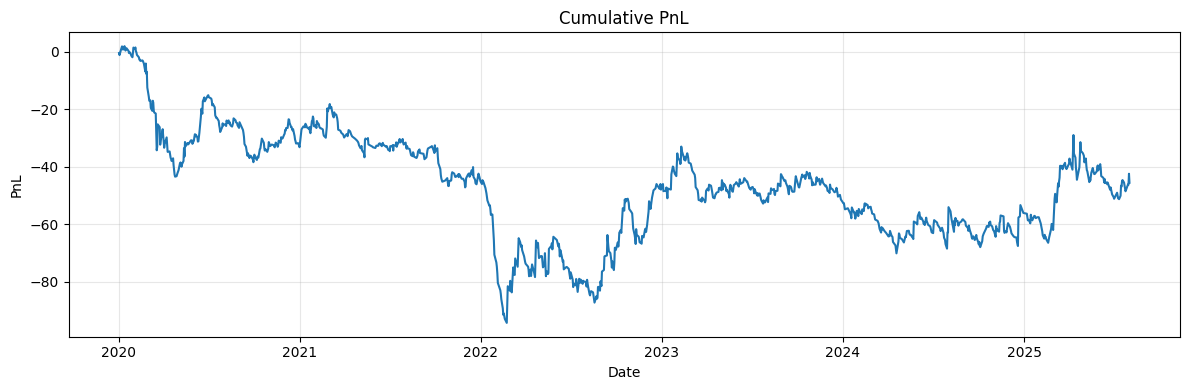

,Date,timeBreach,breach,OR_high,OR_low,timeRetest,timeConfirmationBar,timeExit,entryPrice,exitPrice,...,ema50,ema_alignment,volume60,ADX60,DIp60,DIn60,ADX60_rising3,ATR,NATR,ORB_width
0,2020-01-02,10:11:00,low,324.00,323.41,12:41:00,12:42:00,14:43:00,323.30,323.72,...,321.098323,1,29925,94.169703,17.336585,1.138629,False,1.088863,0.003370,0.182431
1,2020-01-03,10:42:00,high,322.94,321.10,10:46:00,11:45:00,15:59:00,323.10,322.38,...,321.598776,1,42222,81.288298,19.176507,16.290885,False,1.160276,0.003596,0.573030
2,2020-01-06,09:46:00,high,321.43,320.36,09:55:00,09:57:00,15:59:00,321.69,323.61,...,321.843003,1,80736,58.381624,18.020335,19.912363,False,1.049477,0.003255,0.333999
3,2020-01-08,09:53:00,high,323.54,322.67,10:24:00,11:13:00,15:49:00,323.64,324.75,...,322.353723,1,51908,26.603792,20.851126,18.711194,False,0.899041,0.002780,0.269625
4,2020-01-09,09:46:00,low,326.47,325.87,09:48:00,10:02:00,10:40:00,325.78,326.53,...,322.879630,1,67463,25.953374,24.447575,15.537389,False,0.965456,0.002976,0.184123
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1089,2025-07-24,09:47:00,high,634.91,633.99,09:54:00,09:59:00,10:17:00,635.17,634.10,...,628.011180,1,93199,27.222619,35.969261,11.672061,True,1.428511,0.002253,0.145113
1090,2025-07-29,09:48:00,low,638.67,637.93,09:57:00,10:02:00,11:28:00,637.86,635.49,...,632.756108,1,74009,32.240598,25.966579,18.964144,False,1.109081,0.001741,0.116000
1091,2025-07-30,09:45:00,high,636.05,635.29,11:03:00,11:59:00,14:02:00,636.22,636.12,...,633.664124,1,37272,19.579287,24.020484,22.175622,False,1.309101,0.002061,0.119630
1092,2025-07-31,10:50:00,low,639.75,637.82,12:14:00,12:47:00,14:27:00,637.53,633.71,...,634.359902,1,60882,16.917541,24.345256,26.954579,False,2.123122,0.003327,0.302593


In [10]:

def trade_stats(df, pnl_col='returns', r_col=None, equity_start=0.0):
    """
    df must have a PnL column (default: 'returns').
    If you also have an R-multiple column, pass its name via r_col.
    Returns (stats_dict, equity_series, drawdown_series).
    """
    # sort (optional, helps equity curve look right)
    if {'Date','timeExit'}.issubset(df.columns):
        df = df.sort_values(['Date','timeExit'])
    s = pd.Series(df[pnl_col].astype(float).values)
    n = int(s.size)
    if n == 0:
        return {}, pd.Series(dtype=float), pd.Series(dtype=float)

    wins   = s[s > 0]
    losses = s[s < 0]

    gross_profit = float(wins.sum())
    gross_loss   = float(-losses.sum())  # positive number

    win_rate  = float(len(wins) / (len(wins) + len(losses)))
    loss_rate = float(len(losses) / (len(wins) + len(losses)))

    avg_win  = float(wins.mean())   if len(wins)   else 0.0
    avg_loss = float(losses.mean()) if len(losses) else 0.0  # negative
    payoff   = (avg_win / abs(avg_loss)) if len(wins) and len(losses) else np.inf

    profit_factor = (gross_profit / gross_loss) if gross_loss > 0 else np.inf
    expectancy    = win_rate * avg_win + loss_rate * avg_loss  # per trade

    equity = pd.Series(equity_start + s.cumsum(), name='equity')
    run_max = equity.cummax()
    drawdown = equity - run_max
    max_dd = float(drawdown.min())  # negative

    std = float(s.std(ddof=1))
    sharpe_per_trade = (float(s.mean() - 0.04) / std * np.sqrt(n)) if std > 0 and n > 1 else np.nan

    stats = {
        'n_trades': n,
        'win_rate': win_rate,
        'avg_win': avg_win,
        'avg_loss': avg_loss,                 # negative number
        'payoff_ratio': payoff,               # |avg_win| / |avg_loss|
        'expectancy_per_trade': expectancy,   # same units as returns
        'gross_profit': gross_profit,
        'gross_loss': gross_loss,
        'profit_factor': profit_factor,
        'total_pnl': float(s.sum()),
        'median_pnl': float(s.median()),
        'max_drawdown': max_dd,               # same units as returns
        'sharpe_per_trade': sharpe_per_trade
    }

    if r_col and r_col in df.columns:
        r = df[r_col].astype(float)
        stats.update({
            'avg_R': float(r.mean()),
            'median_R': float(r.median()),
            'total_R': float(r.sum()),
            'win_rate_Rpos': float((r > 0).mean())
        })

    return stats, equity, drawdown






rawBacktest = backtest_df.copy(deep=True)


rawBacktest = join_HTF_to_LTF_data(rawBacktest, htf_test)
rawBacktest = rawBacktest[rawBacktest['Date'] != datetime.date(2025, 4, 9)]
rawBacktest = rawBacktest[rawBacktest['Date'] != pd.Timestamp('2025-04-09')]
rawBacktest['ORB_width'] = (rawBacktest['OR_high'] - rawBacktest['OR_low'])/ rawBacktest['OR_low']* 100


temp = backtest_df.copy(deep=True)


temp = join_HTF_to_LTF_data(temp, htf_test)

temp = temp[temp['Date'] != datetime.date(2025, 4, 9)]
temp = temp[temp['Date'] != pd.Timestamp('2025-04-09')]


temp['ORB_width'] = (temp['OR_high'] - temp['OR_low'])/ temp['OR_low']* 100

# temp = temp[(temp['ORB_width'] > 0.15) & (temp['ORB_width'] < 0.5)]
# temp = temp[temp['ORB_width'] < 0.5]

# temp = backtest_df2[backtest_df2['timeConfirmationBar'] > dtime(15, 0)]

# temp = temp[temp['returns'] > 0]
# mask = (temp['breach'] == 'high') & (temp['+DI'] > temp['-DI']) & (temp['ADX'] > 18)
# temp['returns'] = temp['returns'].where(mask, 0) 

# print(temp['ADX'].median())

# mask = ~((temp['breach'] == 'low') & (temp['DIp60'] > temp['DIn60']) & (temp['ADX60'] < 18)) #& (temp['ADX60_rising3'] == False)
# temp['returns'] = temp['returns'].where(mask, 0) 

# temp = temp[(temp['ORB_width'] < 0.5) & (temp['ADX60'] > 18) & (((temp['DIp60'] > temp['DIn60']) & (temp['breach'] == 'high')) | ((temp['DIp60'] < temp['DIn60']) & (temp['breach'] == 'low'))) & (temp['ADX'] > 12)]

# temp = temp[(temp['ORB_width'] < 0.3) & (temp['ADX60'] > 18) & (((temp['ema20'] > temp['ema50']) & (temp['breach'] == 'high')) | ((temp['ema20'] < temp['ema50']) & (temp['breach'] == 'low'))) & (temp['ADX'] > 12) & (((temp['+DI'] > temp['-DI']) & (temp['breach'] == 'high')) | ((temp['+DI'] < temp['-DI']) & (temp['breach'] == 'low'))) & (((temp['entryPrice'] > temp['vwap']) & (temp['breach'] == 'high')) | ((temp['entryPrice'] < temp['vwap']) & (temp['breach'] == 'low')))]

# best win to dd
#[0.3, 18, None, None, None, True, 12, True, False]
# best win rate
#[0.5, 18, None, None, None, None, 20, True, False]


# mask = ~((temp['breach'] == 'high') & (temp['entryPrice'] < temp['vwap']))
# temp['returns'] = temp['returns'].where(mask, 0) 

print('Number of trades: ', temp[temp['returns']!= 0]['returns'].count())
temp['returns'] = temp['returns']# * 50 

stats, equity, dd = trade_stats(temp, pnl_col='returns')  # or r_col='R' if you have it
print(pd.Series(stats))



if 'Date' in temp.columns:
    temp['Date'] = pd.to_datetime(temp['Date'], errors='coerce')
    df = temp.sort_values('Date')

r = pd.to_numeric(df['returns'], errors='coerce').fillna(0)

# 1) Cumulative PnL (use for per-trade PnL/points)
df['cum_pnl'] = r.cumsum()


import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))
plt.plot(df['Date'] if 'Date' in df.columns else df.index, df['cum_pnl'])
plt.title('Cumulative PnL')
plt.xlabel('Date' if 'Date' in df.columns else 'Trade #')
plt.ylabel('PnL')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()



temp

-----------------------------------------------------------
new
-----------------------------------------------------------

In [ ]:
def make_param_grid():
    grid = {
        # HTF regime
        'ORB_width': [None, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8],
        'ADX60': [None, 12, 14, 16, 18, 20, 22, 24],
        'ADX60_rising3': [None, True, False],
        'DIp60_over_DIn60': [None, True, False],
        'NATR': [None, 0.0075, 0.010, 0.0125, 0.0150, 0.0175],
        'ema20_over_ema50': [None, True, False],
        'ADX': [None, 12, 14, 16, 18, 20, 22, 24],
        'DI+_over_DI-': [None, True, False],
        'vwap': [None, True, False],
        'excludeSide': [None, 'high', 'low'],
    }

    keys, vals = zip(*grid.items())
    combos = [dict(zip(keys, v)) for v in product(*vals)]
    return combos

def filterCounterParameters(df, listParams):
    ORB_width = listParams[0]
    ADX60 = listParams[1]
    ADX60_rising3 = listParams[2]
    DIp60_over_DIn60 = listParams[3]
    ema20_over_ema50 = listParams[4]
    ADX = listParams[5]
    DIp_over_DIn = listParams[6]
    vwap = listParams[7]
    excludeSide = listParams[8]

    mask = pd.Series(True, index=df.index)

    # ORB_width
    if ORB_width is not None: mask &= (df['ORB_width'] <= ORB_width)

    # ADX60
    if ADX60 is not None:
        mask &= (df['ADX60'] < ADX60)

    # ADX60 rising
    if ADX60_rising3 is not None:
        mask &= (df['ADX60_rising3'] == ADX60_rising3)

    # DIp60_over_DIn60
    if DIp60_over_DIn60 is not None:
        if DIp60_over_DIn60 == True:
            mask &= (((df['DIp60'] > df['DIn60']) & (df['breach'] == 'high')) | (
                        (df['DIp60'] < df['DIn60']) & (df['breach'] == 'low')))
        elif DIp60_over_DIn60 == False:
            mask &= (((df['DIp60'] < df['DIn60']) & (df['breach'] == 'high')) | (
                        (df['DIp60'] > df['DIn60']) & (df['breach'] == 'low')))
        else:
            print('error with DIp60_over_DIn60')

    # ema20_over_ema50
    if ema20_over_ema50 is not None:
        if ema20_over_ema50 == True:
            mask &= (((df['ema20'] > df['ema50']) & (df['breach'] == 'high')) | (
                        (df['ema20'] < df['ema50']) & (df['breach'] == 'low')))
        elif ema20_over_ema50 == False:
            mask &= (((df['ema20'] < df['ema50']) & (df['breach'] == 'high')) | (
                        (df['ema20'] > df['ema50']) & (df['breach'] == 'low')))
        else:
            print('error with DIp60_over_DIn60')

    # ADX
    if ADX is not None:
        mask &= (df['ADX'] < ADX)

    # DI+_over_DI-
    if DIp_over_DIn is not None:
        if DIp_over_DIn == True:
            mask &= (((df['+DI'] > df['-DI']) & (df['breach'] == 'high')) | (
                        (df['+DI'] < df['-DI']) & (df['breach'] == 'low')))
        elif DIp_over_DIn == False:
            mask &= (((df['+DI'] < df['-DI']) & (df['breach'] == 'high')) | (
                        (df['+DI'] > df['-DI']) & (df['breach'] == 'low')))
        else:
            print('error with +DI_over_-DI')

    # vwap
    if vwap is not None:
        if vwap == True:
            mask &= (((df['vwap'] < df['entryPrice']) & (df['breach'] == 'high')) | (
                        (df['vwap'] > df['entryPrice']) & (df['breach'] == 'low')))
        elif vwap == False:
            mask &= (((df['vwap'] > df['entryPrice']) & (df['breach'] == 'high')) | (
                        (df['vwap'] < df['entryPrice']) & (df['breach'] == 'low')))
        else:
            print('error with vwap')

    if excludeSide is not None:
        if excludeSide == 'high':
            mask &= (df['breach'] != 'high')
        elif excludeSide == 'low':
            mask &= (df['breach'] != 'low')
        else:
            print('error with excludeSide')

    return df[mask]




def filterParameters(df, listParams):
    ORB_width = listParams[0]
    ADX60 = listParams[1]
    ADX60_rising3 = listParams[2]
    DIp60_over_DIn60 = listParams[3]
    ema20_over_ema50 = listParams[4]
    ADX = listParams[5]
    DIp_over_DIn = listParams[6]
    vwap = listParams[7]
    excludeSide = listParams[8]

    mask = pd.Series(True, index=df.index)

    # ORB_width
    if ORB_width is not None: mask &= (df['ORB_width'] <= ORB_width)

    # ADX60
    if ADX60 is not None:
        mask &= (df['ADX60'] > ADX60)

    # ADX60 rising
    if ADX60_rising3 is not None:
        mask &= (df['ADX60_rising3'] == ADX60_rising3)

    # DIp60_over_DIn60
    if DIp60_over_DIn60 is not None:
        if DIp60_over_DIn60 == True:
            mask &= (((df['DIp60'] > df['DIn60']) & (df['breach'] == 'high')) | (
                        (df['DIp60'] < df['DIn60']) & (df['breach'] == 'low')))
        elif DIp60_over_DIn60 == False:
            mask &= (((df['DIp60'] < df['DIn60']) & (df['breach'] == 'high')) | (
                        (df['DIp60'] > df['DIn60']) & (df['breach'] == 'low')))
        else:
            print('error with DIp60_over_DIn60')

    # ema20_over_ema50
    if ema20_over_ema50 is not None:
        if ema20_over_ema50 == True:
            mask &= (((df['ema20'] > df['ema50']) & (df['breach'] == 'high')) | (
                        (df['ema20'] < df['ema50']) & (df['breach'] == 'low')))
        elif ema20_over_ema50 == False:
            mask &= (((df['ema20'] < df['ema50']) & (df['breach'] == 'high')) | (
                        (df['ema20'] > df['ema50']) & (df['breach'] == 'low')))
        else:
            print('error with DIp60_over_DIn60')

    # ADX
    if ADX is not None:
        mask &= (df['ADX'] > ADX)

    # DI+_over_DI-
    if DIp_over_DIn is not None:
        if DIp_over_DIn == True:
            mask &= (((df['+DI'] > df['-DI']) & (df['breach'] == 'high')) | (
                        (df['+DI'] < df['-DI']) & (df['breach'] == 'low')))
        elif DIp_over_DIn == False:
            mask &= (((df['+DI'] < df['-DI']) & (df['breach'] == 'high')) | (
                        (df['+DI'] > df['-DI']) & (df['breach'] == 'low')))
        else:
            print('error with +DI_over_-DI')

    # vwap
    if vwap is not None:
        if vwap == True:
            mask &= (((df['vwap'] < df['entryPrice']) & (df['breach'] == 'high')) | (
                        (df['vwap'] > df['entryPrice']) & (df['breach'] == 'low')))
        elif vwap == False:
            mask &= (((df['vwap'] > df['entryPrice']) & (df['breach'] == 'high')) | (
                        (df['vwap'] < df['entryPrice']) & (df['breach'] == 'low')))
        else:
            print('error with vwap')

    if excludeSide is not None:
        if excludeSide == 'high':
            mask &= (df['breach'] != 'high')
        elif excludeSide == 'low':
            mask &= (df['breach'] != 'low')
        else:
            print('error with excludeSide')

    return df[mask]








import math
import pandas as pd
import numpy as np

def run_param_search(rawBacktest, make_param_grid, min_trades=250):
    """
    Iterate over parameter combinations, filter the backtest DF, compute stats,
    and store *all* parameter + metric rows in a single DataFrame.
    """
    results = []
    count = 0
    
    for p in make_param_grid():
        print(count)
        count = count + 1
        # Unpack with your current names
        ORB_width          = p['ORB_width']
        ADX60              = p['ADX60']
        ADX60_rising3      = p['ADX60_rising3']
        DIp60_over_DIn60   = p['DIp60_over_DIn60']
        ema20_over_ema50   = p['ema20_over_ema50']
        ADX                 = p['ADX']
        DIp_over_DIn        = p['DI+_over_DI-']
        vwap               = p['vwap']
        excludeSide        = p['excludeSide']

        # Filter once per param set
        df_filt = filterParameters(
            rawBacktest.copy(deep=True),
            [ORB_width, ADX60, ADX60_rising3, DIp60_over_DIn60,
             ema20_over_ema50, ADX, DIp_over_DIn, vwap, excludeSide]
        )

        n = len(df_filt)
        if n <= 0:
            # # still log the attempt if you want: set metrics to NaN
            # results.append({
            #     'n_trades': n,
            #     'ORB_width': ORB_width, 'ADX60': ADX60, 'ADX60_rising3': ADX60_rising3,
            #     'DIp60_over_DIn60': DIp60_over_DIn60, 'ema20_over_ema50': ema20_over_ema50,
            #     'ADX': ADX, 'DIp_over_DIn': DIp_over_DIn, 'vwap': vwap, 'excludeSide': excludeSide,
            #     'total_pnl': np.nan, 'win_rate': np.nan, 'avg_win': np.nan, 'avg_loss': np.nan,
            #     'payoff_ratio': np.nan, 'expectancy_per_trade': np.nan, 'gross_profit': np.nan,
            #     'gross_loss': np.nan, 'profit_factor': np.nan, 'median_pnl': np.nan,
            #     'max_drawdown': np.nan, 'sharpe_per_trade': np.nan,
            #     'win_to_drawdown': np.nan, 'pf_adj': np.nan
            # })
            continue

        # Compute stats with your existing function
        stats, equity, dd = trade_stats(df_filt, pnl_col='returns')
        
        if stats.get('total_pnl', np.nan) <= 0:
            continue
        
        # print(pd.Series(stats))
        # Derived metrics that are handy to sort by
        max_dd = stats.get('max_drawdown', np.nan) or np.nan
        total_pnl = stats.get('total_pnl', np.nan) or np.nan
        if pd.notna(max_dd) and max_dd < 0:
            win_to_dd = total_pnl / abs(max_dd) if abs(max_dd) > 1e-9 else np.inf
        else:
            # if no drawdown recorded (or 0), treat very carefully
            win_to_dd = np.inf if pd.notna(total_pnl) and total_pnl > 0 else np.nan

        # A “penalized” profit factor that ignores ultra-low trade counts
        pf = stats.get('profit_factor', np.nan)
        pf_adj = pf if (pd.notna(pf) and n >= max(min_trades, 300)) else np.nan

        # Store row
        results.append({
            'n_trades': n,
            'ORB_width': ORB_width, 'ADX60': ADX60, 'ADX60_rising3': ADX60_rising3,
            'DIp60_over_DIn60': DIp60_over_DIn60, 'ema20_over_ema50': ema20_over_ema50,
            'ADX': ADX, 'DIp_over_DIn': DIp_over_DIn, 'vwap': vwap, 'excludeSide': excludeSide,
            'total_pnl': stats.get('total_pnl', np.nan),
            'win_rate': stats.get('win_rate', np.nan),
            'avg_win': stats.get('avg_win', np.nan),
            'avg_loss': stats.get('avg_loss', np.nan),
            'payoff_ratio': stats.get('payoff_ratio', np.nan),
            'expectancy_per_trade': stats.get('expectancy_per_trade', np.nan),
            'gross_profit': stats.get('gross_profit', np.nan),
            'gross_loss': stats.get('gross_loss', np.nan),
            'profit_factor': pf,
            'median_pnl': stats.get('median_pnl', np.nan),
            'max_drawdown': max_dd,
            'sharpe_per_trade': stats.get('sharpe_per_trade', np.nan),
            'win_to_drawdown': win_to_dd,
            'pf_adj': pf_adj
        })

    results_df = pd.DataFrame(results)

    # Optional: helpful sorts
    # Top by total_pnl
    # results_df.sort_values(['total_pnl','win_to_drawdown','n_trades'], ascending=[False, False, False], inplace=True)

    return results_df




def run_param_search_counter(rawBacktest, make_param_grid, min_trades=250):
    """
    Iterate over parameter combinations, filter the backtest DF, compute stats,
    and store *all* parameter + metric rows in a single DataFrame.
    """
    results = []
    count = 0
    
    for p in make_param_grid():
        print(count)
        count = count + 1
        # Unpack with your current names
        ORB_width          = p['ORB_width']
        ADX60              = p['ADX60']
        ADX60_rising3      = p['ADX60_rising3']
        DIp60_over_DIn60   = p['DIp60_over_DIn60']
        ema20_over_ema50   = p['ema20_over_ema50']
        ADX                 = p['ADX']
        DIp_over_DIn        = p['DI+_over_DI-']
        vwap               = p['vwap']
        excludeSide        = p['excludeSide']

        # Filter once per param set
        df_filt = filterParameters(
            rawBacktest.copy(deep=True),
            [ORB_width, ADX60, ADX60_rising3, DIp60_over_DIn60,
             ema20_over_ema50, ADX, DIp_over_DIn, vwap, excludeSide]
        )

        n = len(df_filt)
        if n <= 0:
            # # still log the attempt if you want: set metrics to NaN
            # results.append({
            #     'n_trades': n,
            #     'ORB_width': ORB_width, 'ADX60': ADX60, 'ADX60_rising3': ADX60_rising3,
            #     'DIp60_over_DIn60': DIp60_over_DIn60, 'ema20_over_ema50': ema20_over_ema50,
            #     'ADX': ADX, 'DIp_over_DIn': DIp_over_DIn, 'vwap': vwap, 'excludeSide': excludeSide,
            #     'total_pnl': np.nan, 'win_rate': np.nan, 'avg_win': np.nan, 'avg_loss': np.nan,
            #     'payoff_ratio': np.nan, 'expectancy_per_trade': np.nan, 'gross_profit': np.nan,
            #     'gross_loss': np.nan, 'profit_factor': np.nan, 'median_pnl': np.nan,
            #     'max_drawdown': np.nan, 'sharpe_per_trade': np.nan,
            #     'win_to_drawdown': np.nan, 'pf_adj': np.nan
            # })
            continue

        # Compute stats with your existing function
        stats, equity, dd = trade_stats(df_filt, pnl_col='returns')
        
        if stats.get('total_pnl', np.nan) <= 0:
            continue
        
        # print(pd.Series(stats))
        # Derived metrics that are handy to sort by
        max_dd = stats.get('max_drawdown', np.nan) or np.nan
        total_pnl = stats.get('total_pnl', np.nan) or np.nan
        if pd.notna(max_dd) and max_dd < 0:
            win_to_dd = total_pnl / abs(max_dd) if abs(max_dd) > 1e-9 else np.inf
        else:
            # if no drawdown recorded (or 0), treat very carefully
            win_to_dd = np.inf if pd.notna(total_pnl) and total_pnl > 0 else np.nan

        # A “penalized” profit factor that ignores ultra-low trade counts
        pf = stats.get('profit_factor', np.nan)
        pf_adj = pf if (pd.notna(pf) and n >= max(min_trades, 300)) else np.nan

        # Store row
        results.append({
            'n_trades': n,
            'ORB_width': ORB_width, 'ADX60': ADX60, 'ADX60_rising3': ADX60_rising3,
            'DIp60_over_DIn60': DIp60_over_DIn60, 'ema20_over_ema50': ema20_over_ema50,
            'ADX': ADX, 'DIp_over_DIn': DIp_over_DIn, 'vwap': vwap, 'excludeSide': excludeSide,
            'total_pnl': stats.get('total_pnl', np.nan),
            'win_rate': stats.get('win_rate', np.nan),
            'avg_win': stats.get('avg_win', np.nan),
            'avg_loss': stats.get('avg_loss', np.nan),
            'payoff_ratio': stats.get('payoff_ratio', np.nan),
            'expectancy_per_trade': stats.get('expectancy_per_trade', np.nan),
            'gross_profit': stats.get('gross_profit', np.nan),
            'gross_loss': stats.get('gross_loss', np.nan),
            'profit_factor': pf,
            'median_pnl': stats.get('median_pnl', np.nan),
            'max_drawdown': max_dd,
            'sharpe_per_trade': stats.get('sharpe_per_trade', np.nan),
            'win_to_drawdown': win_to_dd,
            'pf_adj': pf_adj
        })

    results_df = pd.DataFrame(results)

    # Optional: helpful sorts
    # Top by total_pnl
    # results_df.sort_values(['total_pnl','win_to_drawdown','n_trades'], ascending=[False, False, False], inplace=True)

    return results_df




# results_df = run_param_search_counter(rawBacktest, make_param_grid, min_trades=250)
results_df = run_param_search(rawBacktest, make_param_grid, min_trades=250)
# results_df.to_excel("results.xlsx", index=False)


# backtest_meanReversion_df
# results_df = run_param_search(backtest_meanReversion_df, make_param_grid, min_trades=250)
results_df.to_excel("results_SPY2020-2025.xlsx", index=False)


# 
# 
# 
# bestReturns = 0
# bestWinrate = 0
# bestWinToDrawdown = 0
# 
# for p in make_param_grid():
#     stats, bestReturns, bestWinrate, bestWinToDrawdown = testParameters(rawBacktest,
#                                                                         bestReturns,
#                                                                         bestWinrate,
#                                                                         bestWinToDrawdown,
#                                                                         ORB_width=p['ORB_width'],
#                                                                         ADX60=p['ADX60'],
#                                                                         ADX60_rising3=p['ADX60_rising3'],
#                                                                         DIp60_over_DIn60=p['DIp60_over_DIn60'],
#                                                                         # NATR=p['NATR'],
#                                                                         ema20_over_ema50=p['ema20_over_ema50'],
#                                                                         ADX=p['ADX'],
#                                                                         DIp_over_DIn=p['DI+_over_DI-'],
#                                                                         vwap=p['vwap'],
#                                                                         excludeSide=p['excludeSide']
#                                                                         )
#     # if (len(stats) > 0):
#     #     print(stats['total_pnl'])
#     # print(pd.Series(stats))
# print('bestReturns:\n', pd.Series(bestReturns))
# print('bestWinrate:\n', pd.Series(bestWinrate))
# print('bestWinToDrawdown:\n', pd.Series(bestWinToDrawdown))

-----------------------------------------------------------
END

In [13]:
results_df

,n_trades,ORB_width,ADX60,ADX60_rising3,DIp60_over_DIn60,ema20_over_ema50,ADX,DIp_over_DIn,vwap,excludeSide,...,payoff_ratio,expectancy_per_trade,gross_profit,gross_loss,profit_factor,median_pnl,max_drawdown,sharpe_per_trade,win_to_drawdown,pf_adj
0,40,NaN,NaN,None,None,None,NaN,None,False,high,...,1.914614,0.017500,23.32,22.62,1.030946,-0.385,-12.57,-0.084336,0.055688,NaN
1,444,NaN,NaN,None,None,None,NaN,True,None,low,...,1.505838,0.001332,294.90,294.31,1.002005,-0.370,-52.03,-0.437790,0.011340,1.002005
2,431,NaN,NaN,None,None,None,NaN,True,True,low,...,1.530157,0.019698,290.54,282.07,1.030028,-0.350,-49.00,-0.225723,0.172857,1.030028
3,192,NaN,NaN,None,None,None,NaN,False,None,None,...,1.697691,0.012708,133.52,131.08,1.018615,-0.475,-33.36,-0.196733,0.073141,NaN
4,78,NaN,NaN,None,None,None,NaN,False,None,high,...,2.133328,0.169231,63.47,50.27,1.262582,-0.475,-22.51,0.519848,0.586406,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
838003,33,0.8,24.0,False,False,False,20.0,True,None,high,...,1.069122,0.003333,17.76,17.65,1.006232,-0.350,-9.62,-0.154877,0.011435,NaN
838004,32,0.8,24.0,False,False,False,20.0,True,True,high,...,1.080949,0.041563,17.76,16.43,1.080949,-0.135,-8.40,0.006482,0.158333,NaN
838005,4,0.8,24.0,False,False,False,20.0,False,True,low,...,1.038462,0.550000,3.24,1.04,3.115385,0.890,NaN,0.873851,inf,NaN
838006,31,0.8,24.0,False,False,False,22.0,True,None,high,...,1.145222,0.039032,17.64,16.43,1.073646,-0.350,-8.52,-0.003887,0.142019,NaN


In [26]:
results_df_test = results_df.copy(deep=True)
# results_df_test['']


results_df_test = results_df_test[results_df_test['n_trades'] > 40]
results_df_test = results_df_test[results_df_test['max_drawdown'] > results_df_test['max_drawdown'].median()]
results_df_test = results_df_test[results_df_test['total_pnl']*0.20 > abs(results_df_test['max_drawdown'])]
results_df_test = results_df_test[results_df_test['win_rate'] > results_df_test['win_rate'].median()]
print(results_df_test['max_drawdown'].median())
results_df_test = results_df_test.drop_duplicates()

results_df_test.to_excel("results_SPY2020-2025.xlsx", index=False)
# results_df_test.to_excel("results.xlsx", index=False)
results_df_test

-3.8500000000000227


,n_trades,ORB_width,ADX60,ADX60_rising3,DIp60_over_DIn60,ema20_over_ema50,ADX,DIp_over_DIn,vwap,excludeSide,...,payoff_ratio,expectancy_per_trade,gross_profit,gross_loss,profit_factor,median_pnl,max_drawdown,sharpe_per_trade,win_to_drawdown,pf_adj
9275,57,NaN,NaN,False,True,None,24.0,True,True,low,...,2.117977,0.495263,49.09,20.86,2.353308,0.300,-5.15,2.340422,5.481553,NaN
9393,52,NaN,NaN,False,True,True,24.0,None,True,low,...,2.209155,0.549038,46.65,18.10,2.577348,0.305,-3.61,2.495427,7.908587,NaN
9395,48,NaN,NaN,False,True,True,24.0,True,None,low,...,2.004105,0.447292,39.69,18.22,2.178375,0.225,-3.27,1.922269,6.565749,NaN
9397,47,NaN,NaN,False,True,True,24.0,True,True,low,...,2.090197,0.488936,39.69,16.71,2.375224,0.300,-3.12,2.115468,7.365385,NaN
21688,55,NaN,12.0,False,True,None,24.0,True,True,low,...,2.070959,0.478000,46.36,20.07,2.309915,0.300,-5.15,2.234465,5.104854,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
833990,48,0.8,24.0,False,True,True,16.0,True,None,low,...,2.219753,0.608333,44.95,15.75,2.853968,0.470,-2.51,2.272804,11.633466,NaN
833993,47,0.8,24.0,False,True,True,16.0,True,True,low,...,2.251795,0.599149,43.91,15.75,2.787937,0.430,-2.51,2.190473,11.219124,NaN
834007,46,0.8,24.0,False,True,True,18.0,None,True,low,...,1.768077,0.400870,35.13,16.69,2.104853,0.395,-3.41,1.909558,5.407625,NaN
834008,61,0.8,24.0,False,True,True,18.0,True,None,None,...,1.487165,0.316393,44.94,25.64,1.752730,0.370,-3.76,1.614043,5.132979,NaN


In [16]:


def combineParametersOptimized(tradeInfo_df, filterParameters_df):

    filterParameters_df = filterParameters_df.sort_values(by="win_to_drawdown", ascending=False)

    bestCombination_df = None
    kept_params = []

    for i in range(len(filterParameters_df)):
        row = filterParameters_df.iloc[i]

        listParams = [
            None if pd.isna(x) else x
            for x in [
                row['ORB_width'],
                row['ADX60'],
                row['ADX60_rising3'],
                row['DIp60_over_DIn60'],
                row['ema20_over_ema50'],
                row['ADX'],
                row['DIp_over_DIn'],
                row['vwap'],
                row['excludeSide']
            ]
        ]

        df_filt = filterParameters(tradeInfo_df, listParams)


        if df_filt is not None and len(df_filt):

            if bestCombination_df is None:
                bestCombination_df = df_filt
                kept_params.append(row.to_dict())

            candidate_df = pd.concat([bestCombination_df, df_filt], ignore_index=True).drop_duplicates()

            stats_bestCombination, equity, dd = trade_stats(bestCombination_df, pnl_col='returns')
            stats_candidateCombination, equity, dd = trade_stats(candidate_df, pnl_col='returns')

            if (stats_candidateCombination['total_pnl'] - stats_bestCombination['total_pnl']) - (abs(stats_candidateCombination['max_drawdown']) - abs(stats_bestCombination['max_drawdown'])) >0:
                bestCombination_df = candidate_df.copy(deep=True)
                kept_params.append(row.to_dict())

    # concatenate and drop duplicate rows
    return bestCombination_df, pd.DataFrame(kept_params)




test_optimized, optimizedParams = combineParametersOptimized(rawBacktest, results_df_test)
stats, equity, dd = trade_stats(test_optimized, pnl_col='returns')
print(pd.Series(stats))

n_trades                415.000000
win_rate                  0.473430
avg_win                   1.834286
avg_loss                 -0.917110
payoff_ratio              2.000071
expectancy_per_trade      0.385483
gross_profit            359.520000
gross_loss              199.930000
profit_factor             1.798229
total_pnl               159.590000
median_pnl               -0.100000
max_drawdown            -14.850000
sharpe_per_trade          3.723998
dtype: float64


In [17]:
optimizedParams


,n_trades,ORB_width,ADX60,ADX60_rising3,DIp60_over_DIn60,ema20_over_ema50,ADX,DIp_over_DIn,vwap,excludeSide,...,payoff_ratio,expectancy_per_trade,gross_profit,gross_loss,profit_factor,median_pnl,max_drawdown,sharpe_per_trade,win_to_drawdown,pf_adj
0,41,NaN,22.0,False,None,True,22.0,None,True,low,...,2.570185,0.733415,41.51,11.44,3.628497,0.520,-1.47,3.147349,20.455782,NaN
1,44,0.3,18.0,False,None,True,24.0,None,True,None,...,2.658414,0.708864,39.73,8.54,4.652225,0.500,-1.76,3.545727,17.721591,NaN
2,74,0.5,22.0,False,None,True,14.0,None,True,low,...,2.471429,0.580676,67.47,24.50,2.753878,0.405,-2.49,2.901305,17.257028,NaN
3,72,0.5,24.0,False,True,True,14.0,None,True,None,...,2.137229,0.558194,66.53,26.34,2.525816,0.470,-2.37,2.637778,16.957806,NaN
4,68,0.6,22.0,False,None,True,16.0,None,True,low,...,2.526764,0.593971,62.31,21.92,2.842609,0.455,-2.49,2.831120,16.220884,NaN
5,61,0.5,22.0,False,None,True,14.0,True,None,low,...,2.354168,0.571639,54.52,19.65,2.774555,0.430,-2.23,2.534522,15.636771,NaN
6,61,0.5,24.0,False,None,True,20.0,None,True,None,...,2.035123,0.726393,65.04,20.73,3.137482,0.520,-2.98,2.776740,14.869128,NaN
7,67,0.6,24.0,False,None,True,20.0,None,True,None,...,2.006612,0.664925,69.37,24.82,2.794923,0.510,-3.39,2.682841,13.141593,NaN
8,48,0.3,18.0,False,None,True,22.0,None,True,low,...,2.417947,0.513542,37.92,13.27,2.857573,0.220,-1.90,2.614751,12.973684,NaN
9,42,0.3,NaN,False,True,None,24.0,None,True,low,...,2.906602,0.663810,38.95,11.07,3.518519,0.440,-2.17,2.998199,12.847926,NaN


In [18]:
SPY_Data = get1minBars('1_min_SPY_2008-2021.csv')
SPY_Data

,Date,Time,open,high,low,close,volume
82860,2008-01-22,09:30:00,130.77,130.79,130.59,130.76,5937
82861,2008-01-22,09:31:00,130.76,130.77,130.33,130.34,7680
82862,2008-01-22,09:32:00,130.34,130.41,130.26,130.33,6649
82863,2008-01-22,09:33:00,130.34,130.35,130.14,130.19,8051
82864,2008-01-22,09:34:00,130.19,130.20,129.90,129.94,21850
...,...,...,...,...,...,...,...
841095,2021-05-06,13:55:00,418.56,418.77,418.48,418.49,9073
841096,2021-05-06,13:56:00,418.50,418.73,418.47,418.64,6680
841097,2021-05-06,13:57:00,418.64,418.79,418.63,418.79,6912
841098,2021-05-06,13:58:00,418.79,418.83,418.71,418.76,7891


In [19]:
htf_test = HTF(SPY_Data)
htf_test

,Date,Time,open,high,low,close,volume60,ema20,ema50,ema_alignment,ADX60,DIp60,DIn60,ADX60_rising3,ATR,NATR
0,2008-01-22,09:30:00,130.77,131.28,129.90,130.64,350721,NaN,NaN,0,NaN,NaN,NaN,False,NaN,NaN
1,2008-01-22,10:30:00,130.63,131.90,130.22,131.00,307599,130.640000,130.640000,0,NaN,0.000000,0.000000,False,1.380000,0.010563
2,2008-01-22,11:30:00,131.00,131.59,130.07,130.72,388059,130.674286,130.654118,1,100.000000,3.160041,0.000000,False,1.401429,0.010698
3,2008-01-22,12:30:00,130.70,131.68,130.13,131.07,369561,130.678639,130.656701,1,97.047244,2.916697,0.759933,False,1.409898,0.010786
4,2008-01-22,13:30:00,131.07,132.21,130.43,130.63,414749,130.715912,130.672909,1,94.653293,3.142020,0.700679,False,1.419905,0.010833
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17097,2021-05-06,09:30:00,416.08,417.58,415.96,417.52,84881,416.455507,416.163899,1,17.908994,22.487643,31.279508,False,1.442072,0.003469
17098,2021-05-06,10:30:00,417.53,417.57,416.41,416.70,51957,416.556888,416.217079,1,16.758880,27.459152,28.470008,False,1.471210,0.003524
17099,2021-05-06,11:30:00,416.71,416.96,415.74,415.93,56491,416.570517,416.236017,1,15.690916,25.888954,26.842006,False,1.448981,0.003477
17100,2021-05-06,12:30:00,415.94,417.21,415.66,417.03,74321,416.509516,416.224017,1,15.142441,24.314196,28.549798,False,1.432625,0.003444


In [20]:
BO_and_retest = getORB_retest_data(SPY_Data)
BO_and_retest

,Date,timeBreach,breach,OR_high,OR_low,timeRetest,timeConfirmationBar
0,2008-01-22,09:52:00,high,130.79,129.90,10:13:00,10:55:00
1,2008-01-23,09:47:00,low,129.47,128.35,10:13:00,10:16:00
2,2008-01-24,09:47:00,high,134.73,134.33,09:49:00,09:51:00
3,2008-01-25,10:48:00,low,135.40,134.50,10:50:00,10:52:00
4,2008-01-28,10:05:00,low,134.45,133.84,10:24:00,10:26:00
...,...,...,...,...,...,...,...
2678,2021-04-28,09:46:00,low,417.93,417.54,10:07:00,11:48:00
2679,2021-04-30,09:45:00,high,417.44,416.71,09:50:00,09:53:00
2680,2021-05-03,12:30:00,high,418.94,418.14,12:38:00,12:40:00
2681,2021-05-05,09:52:00,high,417.36,416.60,09:54:00,09:55:00


In [25]:

SPY_Data_VWAP = SPY_Data.copy(deep=True)

SPY_Data_VWAP['pv'] = (SPY_Data_VWAP['high'] + SPY_Data_VWAP['low'] + SPY_Data_VWAP['close']) * SPY_Data_VWAP['volume'] / 3
SPY_Data_VWAP['cum_pv'] = SPY_Data_VWAP.groupby('Date')['pv'].cumsum()
SPY_Data_VWAP['cum_vol'] = SPY_Data_VWAP.groupby('Date')['volume'].cumsum()
SPY_Data_VWAP['vwap'] = SPY_Data_VWAP['cum_pv'] / SPY_Data_VWAP['cum_vol']
previous_vwap = SPY_Data_VWAP.groupby('Date')['vwap'].last()
SPY_Data_VWAP['previous_vwap'] = SPY_Data_VWAP['Date'].map(previous_vwap.shift(1))

SPY_Data_VWAP = SPY_Data_VWAP.sort_values(['Date', 'Time']).copy()

SPY_Data_VWAP['bar_range'] = SPY_Data_VWAP['high'] - SPY_Data_VWAP['low']

SPY_Data_VWAP['range_ma_30m'] = (
    SPY_Data_VWAP
      .groupby('Date', group_keys=False)['bar_range']
      .rolling(window=30, min_periods=1)  # 30 bars = 30 minutes
      .mean()
      .reset_index(level=0, drop=True)
)
SPY_Data_VWAP['range_ma_30m'].shift(1)

# SPY_Data_VWAP = SPY_Data_VWAP.iloc[390:,]
# SPY_Data_VWAP




# df has columns: Date, Open, High, Low, Close, Volume
adx_df = adx(SPY_Data, period=14)
adx_df = SPY_Data_VWAP.join(adx_df)
adx_df['ADX'] = adx_df['ADX'].shift(1)


adx_df = adx_df.iloc[390:,]



# Run backtest
backtest = []
for d in BO_and_retest['Date'].unique():
    b = runBacktest_WithTargets(adx_df, d, BO_and_retest)
    if b:
        backtest.append(b)

backtest_df = pd.DataFrame(backtest)
print("Total PnL:", backtest_df['returns'].sum())
backtest_df

AssertionError: No intraday data for 2008-01-22

In [ ]:


def backtestOptimizedParameters(tradeInfo_df, optimizedParams_df):

    
    for i in range(len(optimizedParams_df)):
        row = optimizedParams_df.iloc[i]

        listParams = [
            None if pd.isna(x) else x
            for x in [
                row['ORB_width'],
                row['ADX60'],
                row['ADX60_rising3'],
                row['DIp60_over_DIn60'],
                row['ema20_over_ema50'],
                row['ADX'],
                row['DIp_over_DIn'],
                row['vwap'],
                row['excludeSide']
            ]
        ]

        df_filt = filterParameters(tradeInfo_df, listParams)


        if df_filt is not None and len(df_filt):

            if filteredBacktest is None:
                filteredBacktest = df_filt
                

            filteredBacktest = pd.concat([filteredBacktest, df_filt], ignore_index=True).drop_duplicates()

 
                

    # concatenate and drop duplicate rows
    return filteredBacktest


backtestSPY_df = combineParametersOptimized(backtest_df, optimizedParams)
backtestSPY_df

In [ ]:
stats, equity, dd = trade_stats(backtestSPY_df, pnl_col='returns')
print(pd.Series(stats))